# Omi Ceti: PyMC GP Fitting (periodic)

Fitting a periodic kernel to [Mira](https://en.wikipedia.org/wiki/Mira) lightcurve which is known to be periodic.

Data sourced from here: <https://github.com/bersavosh/Random/tree/master/rand_files>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp
import pandas as pd
import xarray as xr
from pymc.gp.util import plot_gp_dist
from scipy.fftpack import fft, ifft, fftfreq, fftshift

#import graphviz

RANDOM_SEED = 1
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
#az.style.use("arviz-doc")

# Setting matplotlib fonts
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

print(f"Running on PyMC v{pm.__version__}")

EXECUTE_SAMPLING = False

Running on PyMC v5.1.2


## Data

In [3]:
series_fname = "Omi_Ceti"
series_raw = pd.read_csv(f"data_raw/{series_fname}.csv").iloc[np.arange(720, 2720, 10)]

t = series_raw["day"].to_numpy()
y = series_raw["magnitude"].to_numpy()

y_mean = np.mean(y)

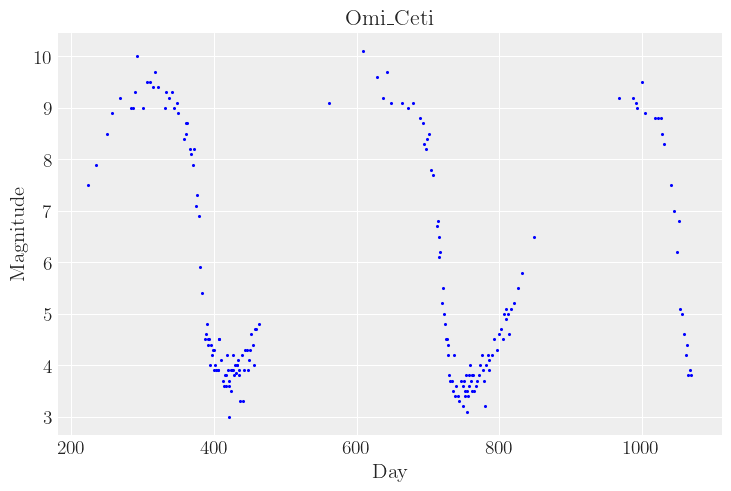

In [4]:
fig1 = plt.figure()
ax = fig1.add_subplot(1,1,1)

plt.scatter(x=t, y=y, s=1.5, c="b")
plt.xlabel("Day")
plt.ylabel("Magnitude")
_ = plt.title(f"{series_fname}")

## Kernel

Choose a periodic kernel, i.e., sinusoidal.

$$\textrm{Periodic kernel} \qquad k(\tau) = \eta^2 \mathrm{exp}\left\{ -\frac{1}{2}\left[\frac{\sin\left(\pi \frac{\tau}{T}\right)}{\ell}\right]^2 \right\}$$

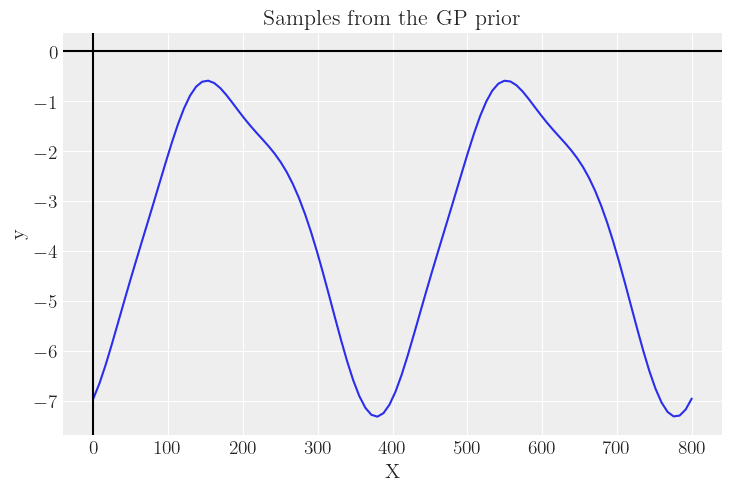

In [5]:
this_eta = 8
this_T = 400
this_ell = 1
this_cov = this_eta**2 * pm.gp.cov.Periodic(1, period=this_T, ls=this_ell)
# Add white noise to stabilise
this_cov += pm.gp.cov.WhiteNoise(1e-6)
this_X = np.linspace(0, 800, 100)[:, None]
this_K = this_cov(this_X).eval()
plt.plot(
    this_X,
    pm.draw(pm.MvNormal.dist(mu=y_mean, cov=this_K, shape=len(this_K)), draws=1, random_seed=rng).T,
)
for p in np.arange(0, 2, this_T):
    plt.axvline(p, color="black")
plt.axhline(0, color="black")
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

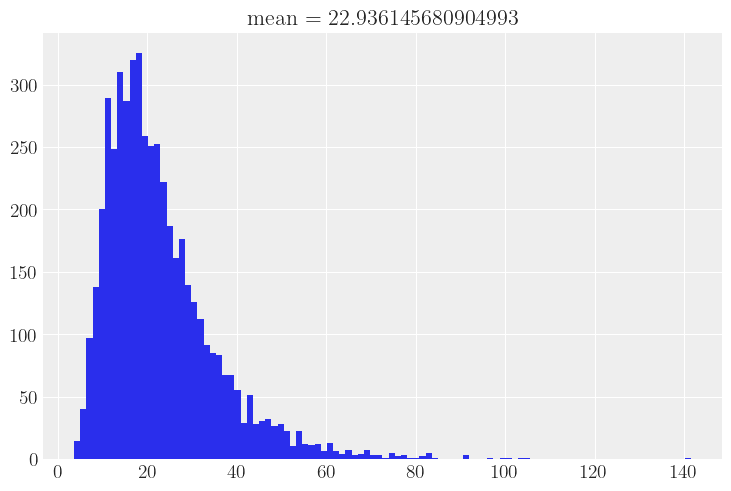

In [6]:
z = pm.LogNormal.dist(mu=3, sigma=0.5)
z_draws = pm.draw(z, draws=5000)

fig = plt.figure()
ax = plt.gca()
ax.hist(z_draws, 100)
ax.set_title(f"mean $= {z_draws.mean()}$");

In [7]:
with pm.Model() as model:
    # Periodic
    eta = pm.HalfNormal("eta", sigma=8.0)
    ell = pm.Gamma(name="ell", alpha=10, beta=5)
    T = pm.LogNormal(name="T", mu=5.6, sigma=0.25)
        
    mean_fn = pm.gp.mean.Constant(c = y_mean)
    cov_fn = eta**2 * pm.gp.cov.Periodic(1, period=T, ls=ell) +  pm.gp.cov.WhiteNoise(1e-6)
    
    gp = pm.gp.Marginal(mean_func=mean_fn, cov_func=cov_fn)

    # noise model
    sigma = pm.HalfNormal(name="sigma", sigma=1.0)
    cov_noise = pm.gp.cov.WhiteNoise(sigma)

    # Likelihood
    y_ = gp.marginal_likelihood("y", X=t.reshape(-1,1), y=y.reshape(-1,1).flatten(), sigma=cov_noise)

In [8]:
with model:
    if EXECUTE_SAMPLING:
        idata = pm.sample_prior_predictive(samples=100, random_seed=rng)
    else:
        idata = az.from_netcdf(f"traces/{series_fname}1_periodic_idata.nc")

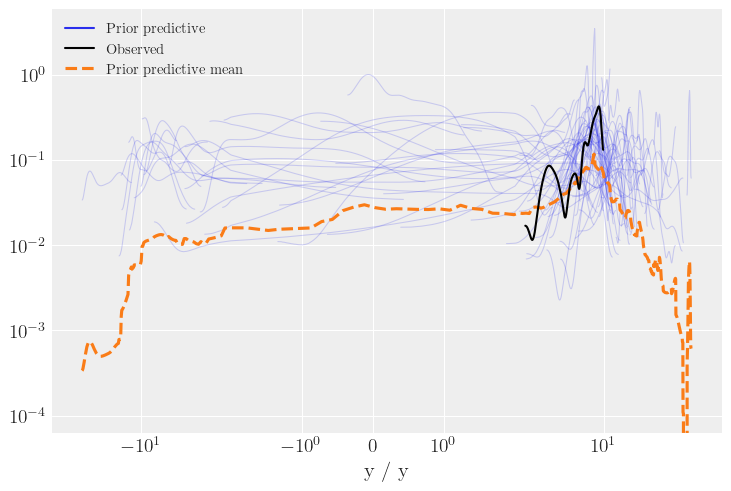

In [9]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
az.plot_ppc(idata, group='prior', ax=ax2);
ax2.set_xscale('symlog')
ax2.set_yscale('log');

**NB:** Flux cannot be negative so more contraints can be put on these priors

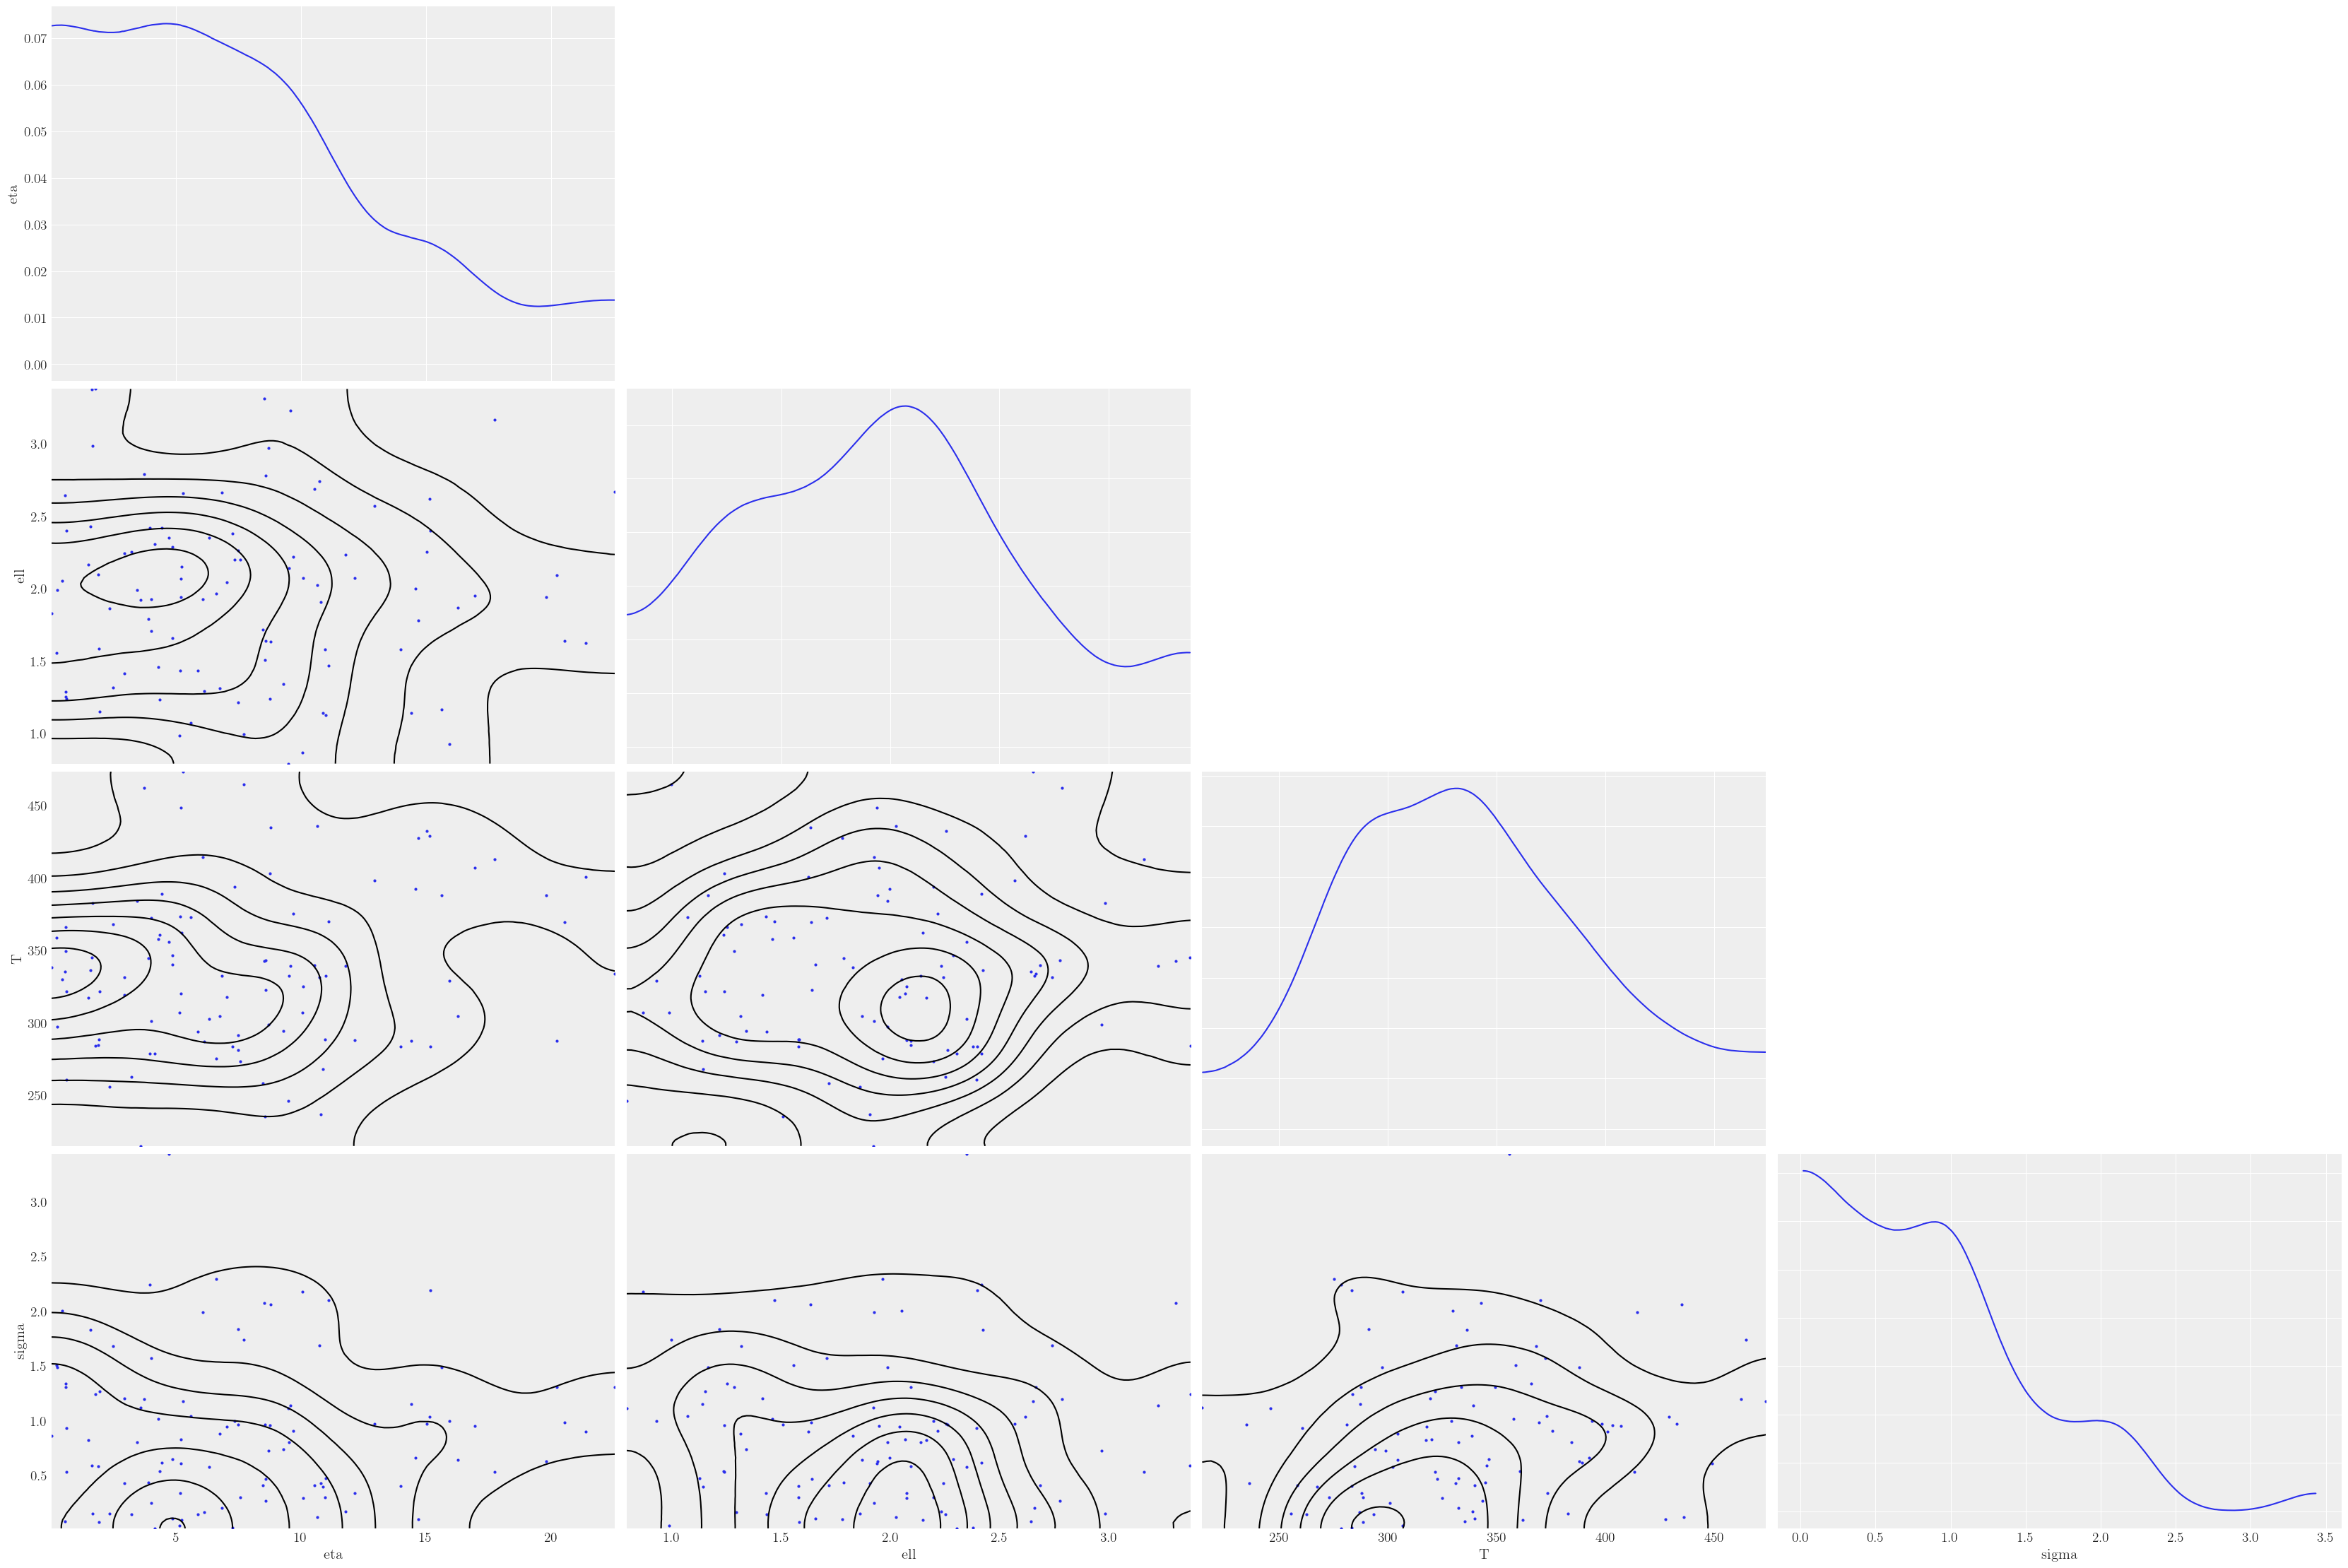

In [10]:
az.plot_pair(idata, group='prior', var_names=['eta', 'ell', 'T', 'sigma'], kind=['scatter','kde'], marginals=True);

In [11]:
with model:
    if EXECUTE_SAMPLING:
        idata.extend(pm.sample(random_seed=rng))

In [12]:
az.summary(idata, var_names=["eta", "ell", "T", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,3.021,1.172,1.586,4.970,0.178,0.127,80.0,63.0,1.05
ell,0.255,0.107,0.151,0.479,0.047,0.035,7.0,39.0,1.53
T,576.372,140.768,331.535,661.102,70.095,53.670,7.0,30.0,1.53
sigma,0.317,0.041,0.263,0.399,0.018,0.014,7.0,27.0,1.53


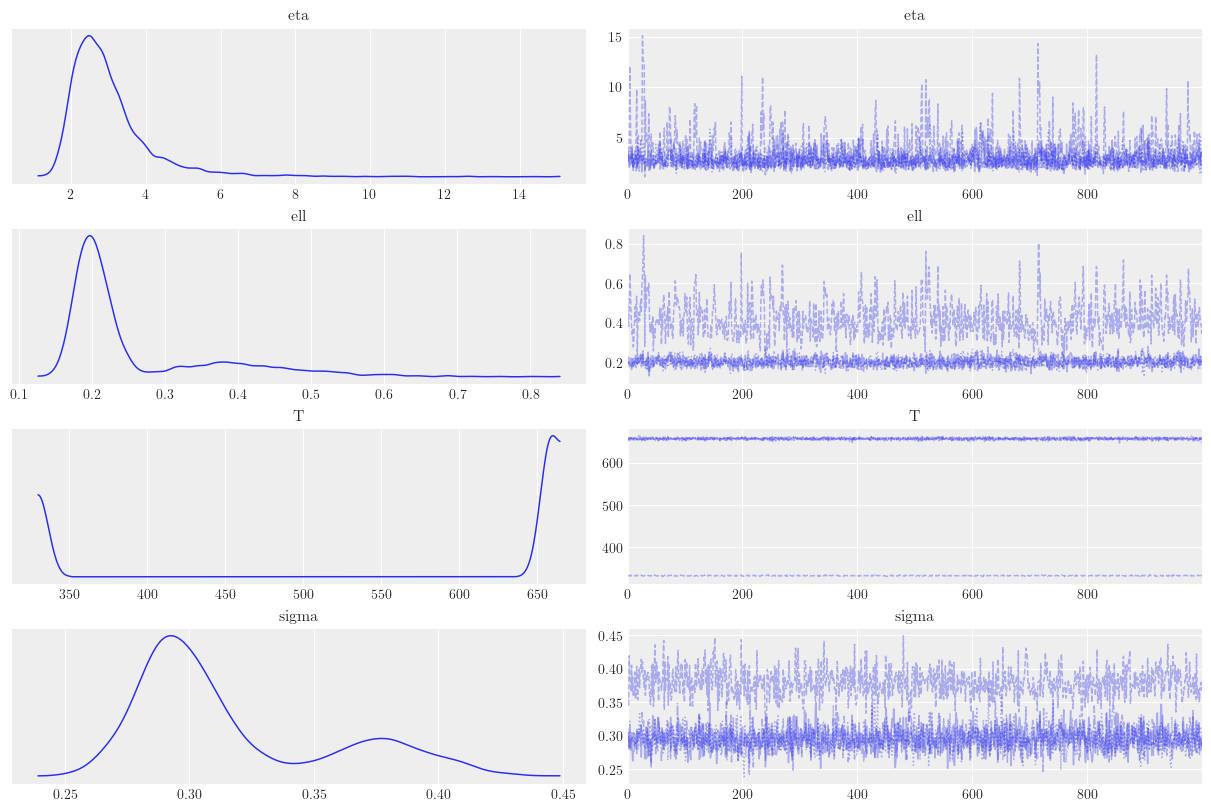

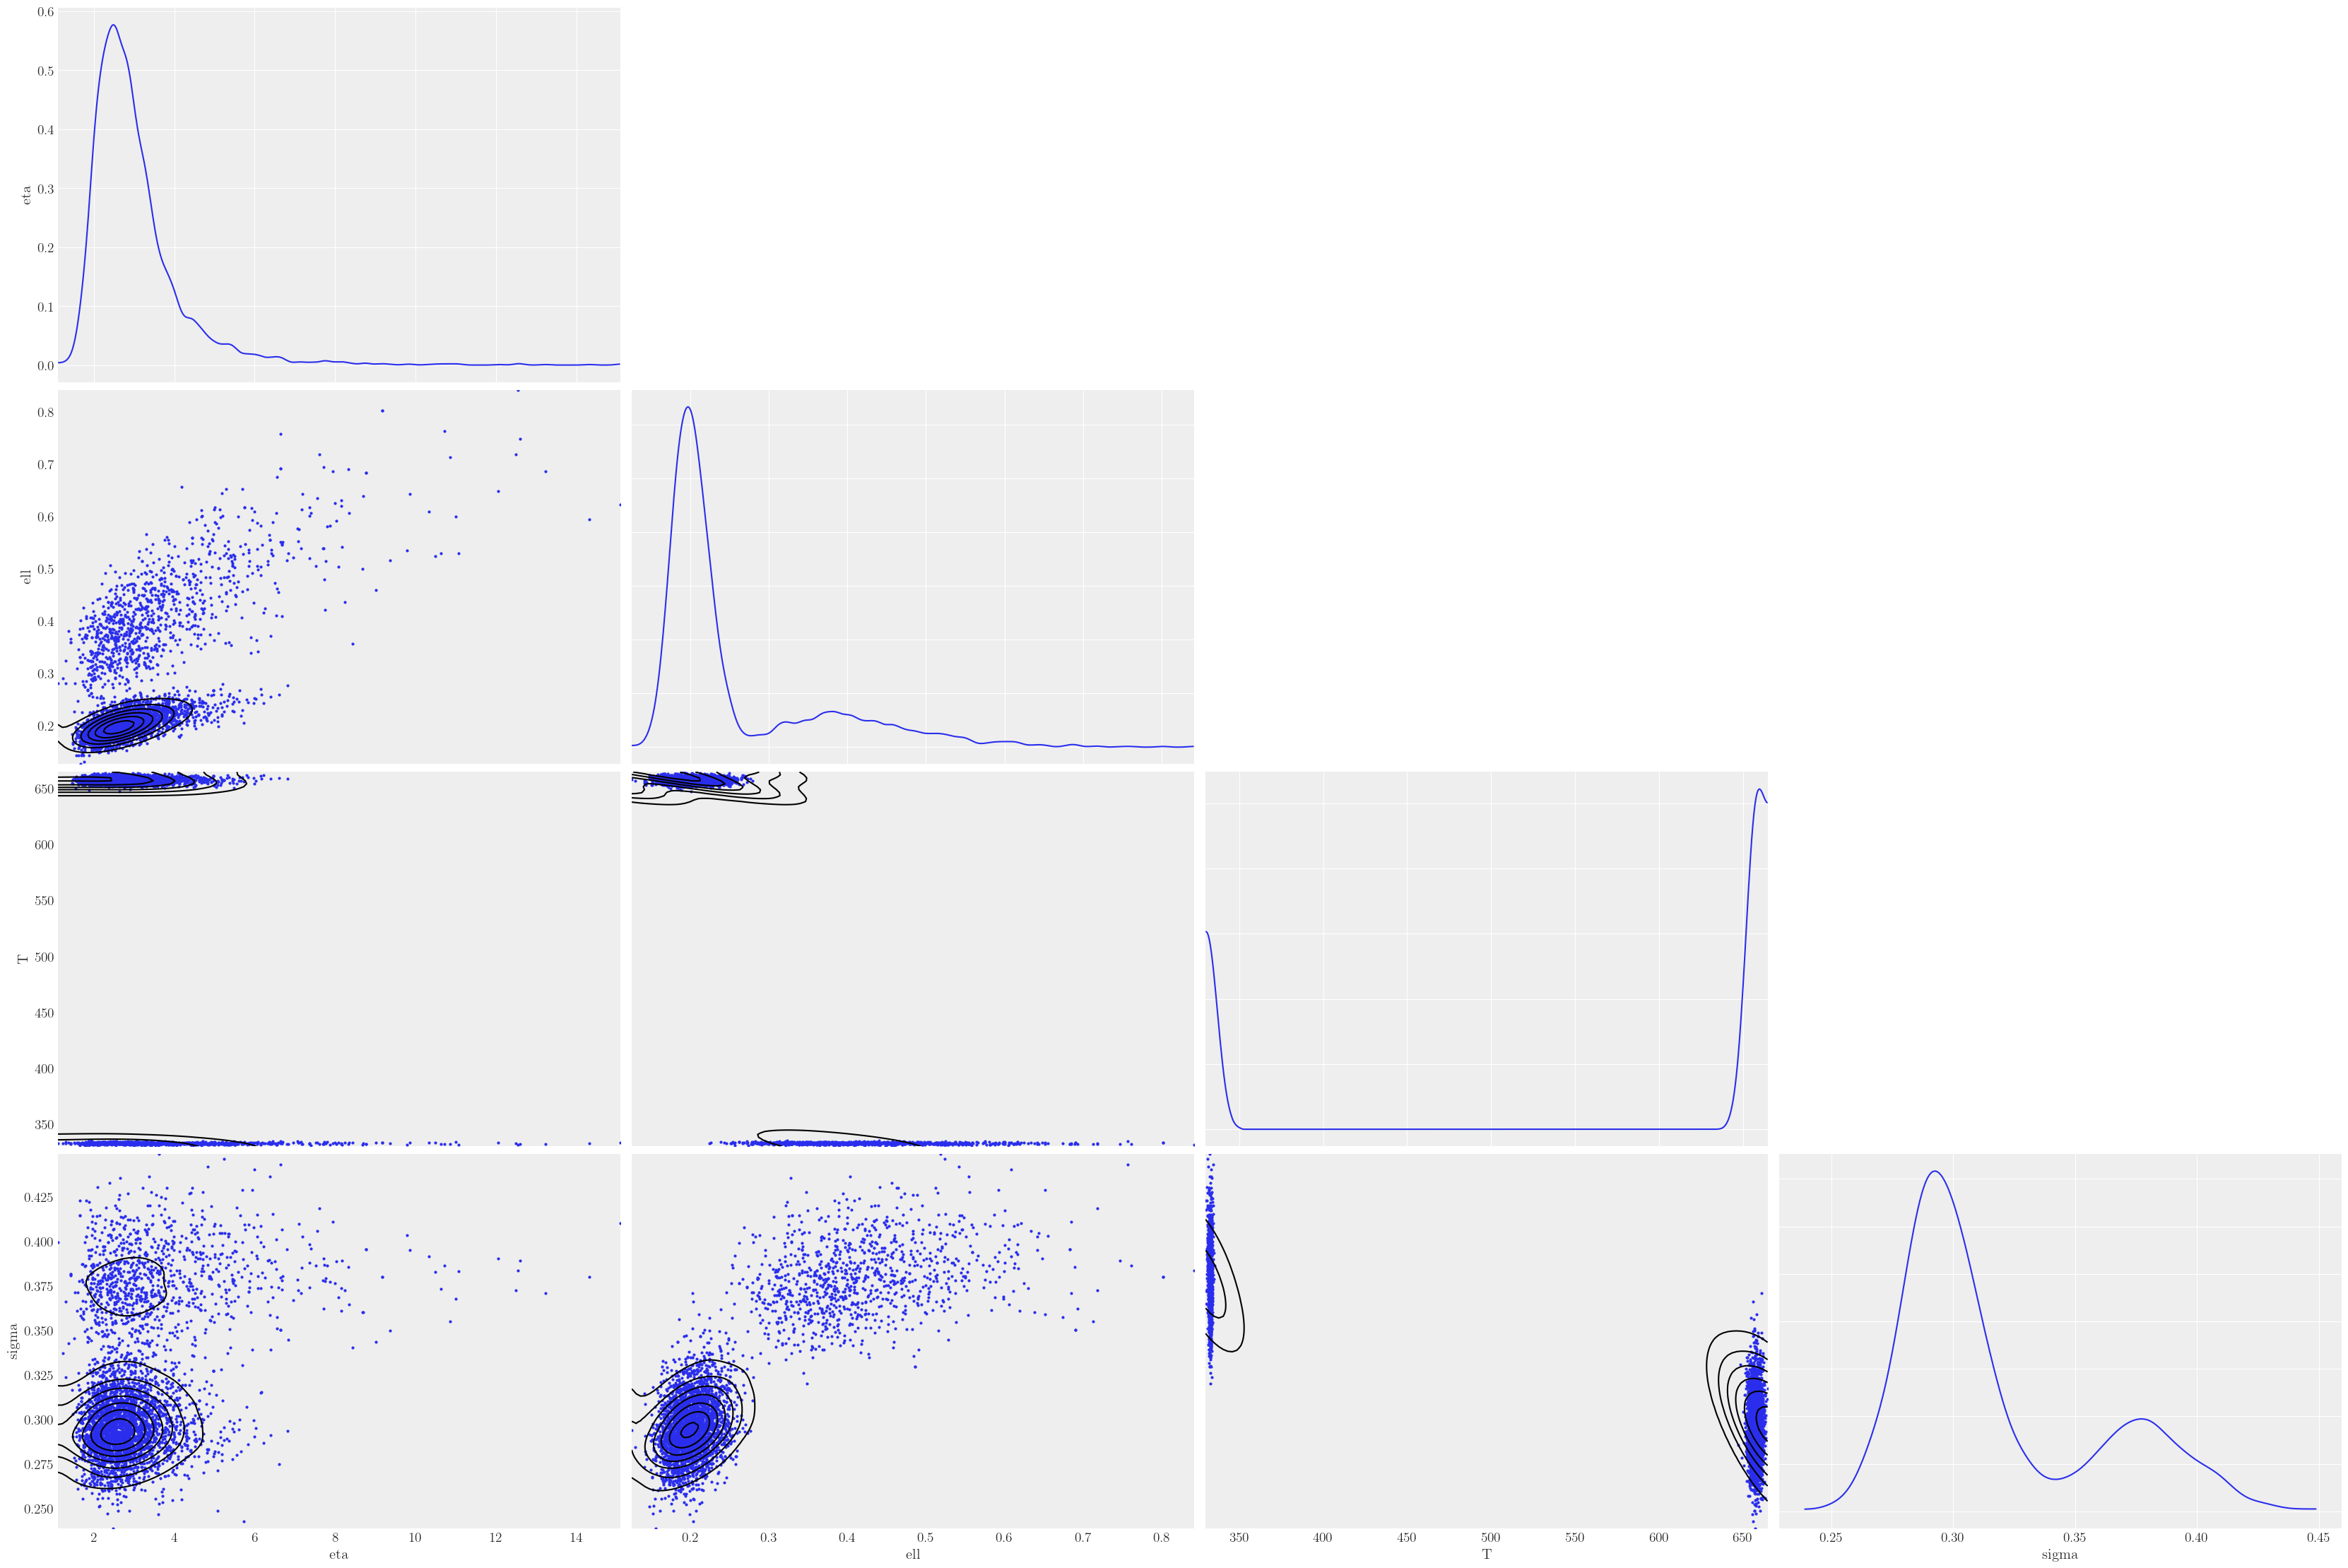

In [13]:
az.plot_trace(idata, combined=True);
az.plot_pair(idata, kind=['scatter','kde'], marginals=True);

In [14]:
RESAMPLE_INTERVAL = 1 # days between samples

t_new = np.linspace(np.floor(t.min()), 
                    np.ceil(t.max()), 
                    num = np.ceil((t.max() - t.min())/RESAMPLE_INTERVAL).astype(int)).reshape(-1,1)

with model:
    if EXECUTE_SAMPLING:
        f_pred = gp.conditional("f_pred", t_new)

In [15]:
#thinned_idata = idata.sel(draw=slice(None, None, 5))

with model:
    if EXECUTE_SAMPLING:
        pred_samples = pm.sample_posterior_predictive(idata, var_names=["f_pred"])
        idata.extend(pred_samples)
        az.to_netcdf(idata, f"traces/{series_fname}1_periodic_idata.nc")

<Axes: xlabel='y / f_pred'>

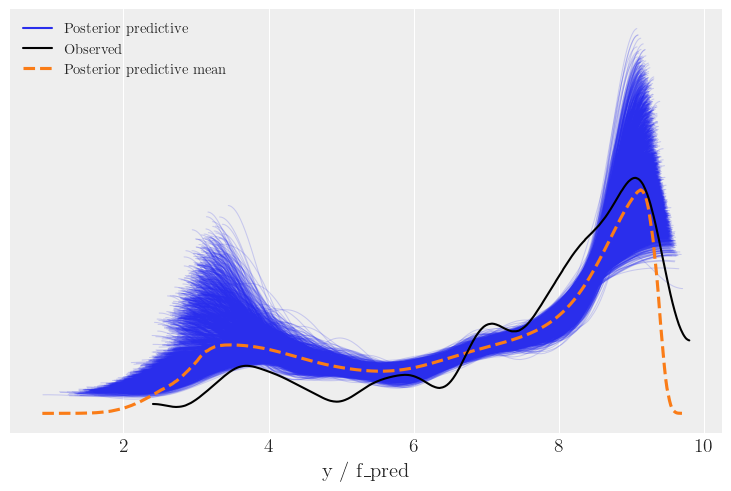

In [16]:
az.plot_ppc(idata, data_pairs={"y":"f_pred"});

ValueError: operands could not be broadcast together with shapes (845,) (118,) 

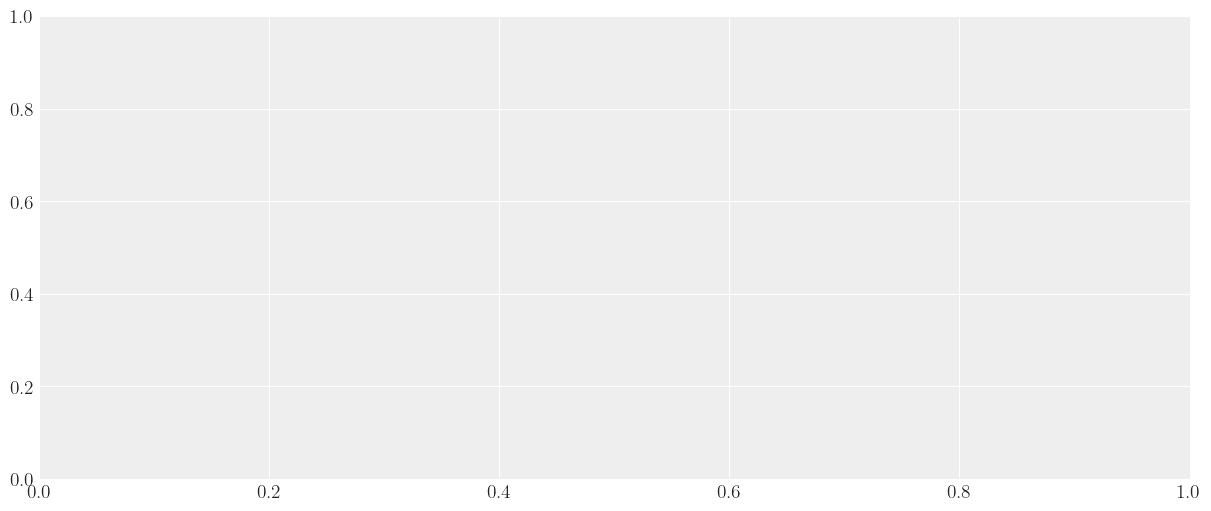

In [17]:
fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.gca()

plot_gp_dist(ax3, 
             az.extract(idata.posterior_predictive,
                        var_names=['f_pred']).transpose("sample", ...), 
                        t_new, 
             plot_samples=True)

plt.plot(t, y, "ok", ms=5, alpha=0.5, label="Observed data")

## Power Spectral Density

In [18]:
post_pred = idata.posterior_predictive.f_pred.stack(draws=("chain", "draw"))

fft_N = 2**10

xf = fftfreq(fft_N, RESAMPLE_INTERVAL)[1:fft_N//2]
yf = fft(post_pred.to_numpy().T, n=fft_N, axis=1)[1:fft_N//2]

fft_psf = np.abs(yf)**2/fft_N

/tmp/ipykernel_6449/3458137304.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  fft_q67 = az.hdi(fft_psf.T, hdi_prob=0.67)
/tmp/ipykernel_6449/3458137304.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  fft_q95 = az.hdi(fft_psf.T, hdi_prob=0.95)


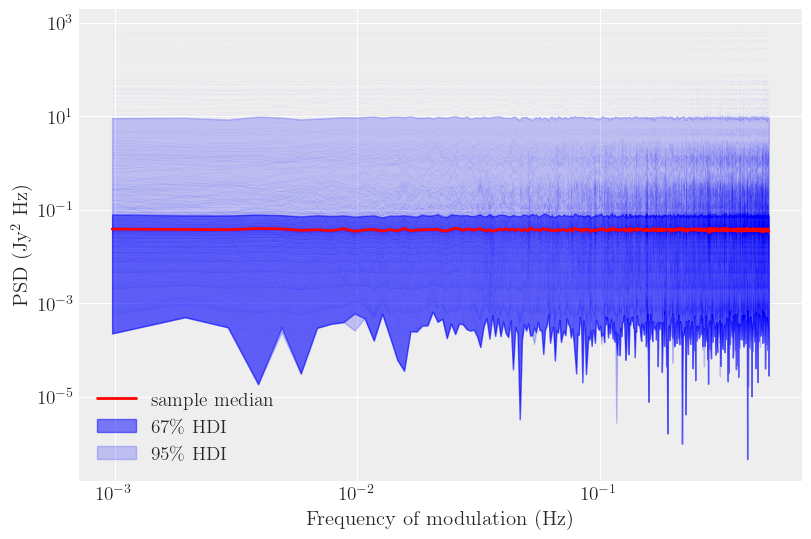

In [19]:
fft_q67 = az.hdi(fft_psf.T, hdi_prob=0.67)
fft_q95 = az.hdi(fft_psf.T, hdi_prob=0.95)

fig4 = plt.figure(figsize=(8,10))
ax4 = fig4.add_subplot(2,1,1)
ax4.loglog(xf, fft_psf,lw=0.1,color='b',alpha=0.05)
ax4.loglog(xf, np.median(fft_psf,axis=1),lw=2,color='r', label='sample median')
ax4.fill_between(xf, fft_q67.T[0], fft_q67.T[1], alpha=0.5, color='b', label='67\% HDI')
ax4.fill_between(xf, fft_q95.T[0], fft_q95.T[1], alpha=0.2, color='b', label='95\% HDI')
ax4.set_xlabel('Frequency of modulation (Hz)')
ax4.set_ylabel(r'PSD (Jy$^2$ Hz)')
#ax4.set_xlim(xf[0], xf[-1])
ax4.legend();